# **Name:** Shriya Haral
# **MIS No.:** 242062004
## **Topic:** Gold Price Prediction using ARIMA Model in Python

In [ ]:
#Importing Required Libraries 
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file 
import matplotlib.pyplot as plt #For plots 

## timeseries package
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from datetime import timedelta
from numpy import log

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#Reading CSV File
df = pd.read_csv("/content/gold_rate_history.csv")
df.shape #Displaying shape of the dataset

(4971, 6)

In [ ]:
df.columns #Columns in the dataset

Index(['Date', 'Country', 'State', 'Location', 'Pure Gold (24 k)',
       'Standard Gold (22 K)'],
      dtype='object')

In [ ]:
print(f"The dataset available for State: {df['State'].unique()[0]} and City: {df['Location'].unique()[0]}") 

The dataset available for State: Tamilnadu and City: Chennai


Convert Datetime object

In [ ]:
## Convert date string to datetime object
df["Date"] = pd.to_datetime(df["Date"], format="%m/%d/%Y")

In [ ]:
print(f'The date ranging from {df["Date"].min()} to {df["Date"].max()}')

The date ranging from 2006-01-02 00:00:00 to 2020-10-10 00:00:00


In [ ]:
df["Pure Gold (24 k)"] = df["Pure Gold (24 k)"].astype(np.float)
df["Standard Gold (22 K)"] = df["Standard Gold (22 K)"].astype(np.float)

In [ ]:
df.index = df.Date

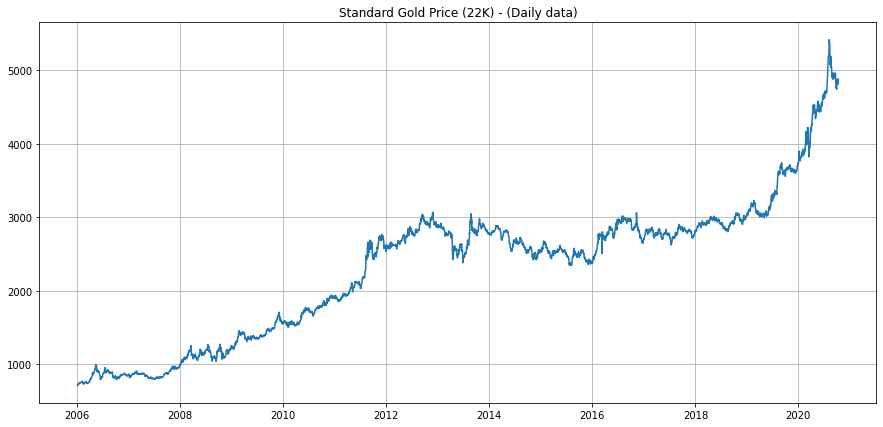

In [ ]:
plt.figure(figsize=(15, 7))
plt.plot(df['Standard Gold (22 K)'])
plt.title('Standard Gold Price (22K) - (Daily data)')
plt.grid(True)
plt.show()

# **ARIMA model**
The important parameters of ARIMA is p, d and q. 

In [ ]:
result = adfuller(df['Standard Gold (22 K)'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.542589
p-value: 0.986112


P value is not significant 0.05 hence the data is not stationary. it required order of differencing (D).

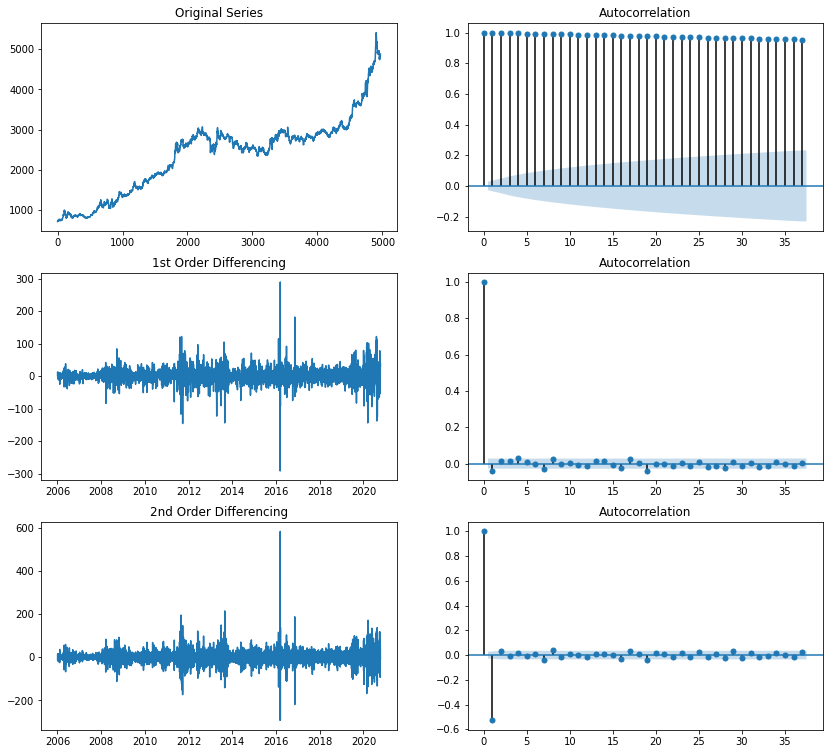

In [ ]:
# Original Series
fig, axes = plt.subplots(3, 2, sharex=False)

fig.set_size_inches(14,13)

axes[0, 0].plot(df['Standard Gold (22 K)'].values); axes[0, 0].set_title('Original Series')
plot_acf(df['Standard Gold (22 K)'].values, ax=axes[0, 1])


# 1st Differencing
axes[1, 0].plot(df['Standard Gold (22 K)'].diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df['Standard Gold (22 K)'].diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df['Standard Gold (22 K)'].diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df['Standard Gold (22 K)'].diff().diff().dropna(), ax=axes[2, 1])

plt.show()

Looking at the autocorrelation plot for the 2nd differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.

Will fix order of differencing as 1. This is the d term in ARIMA.

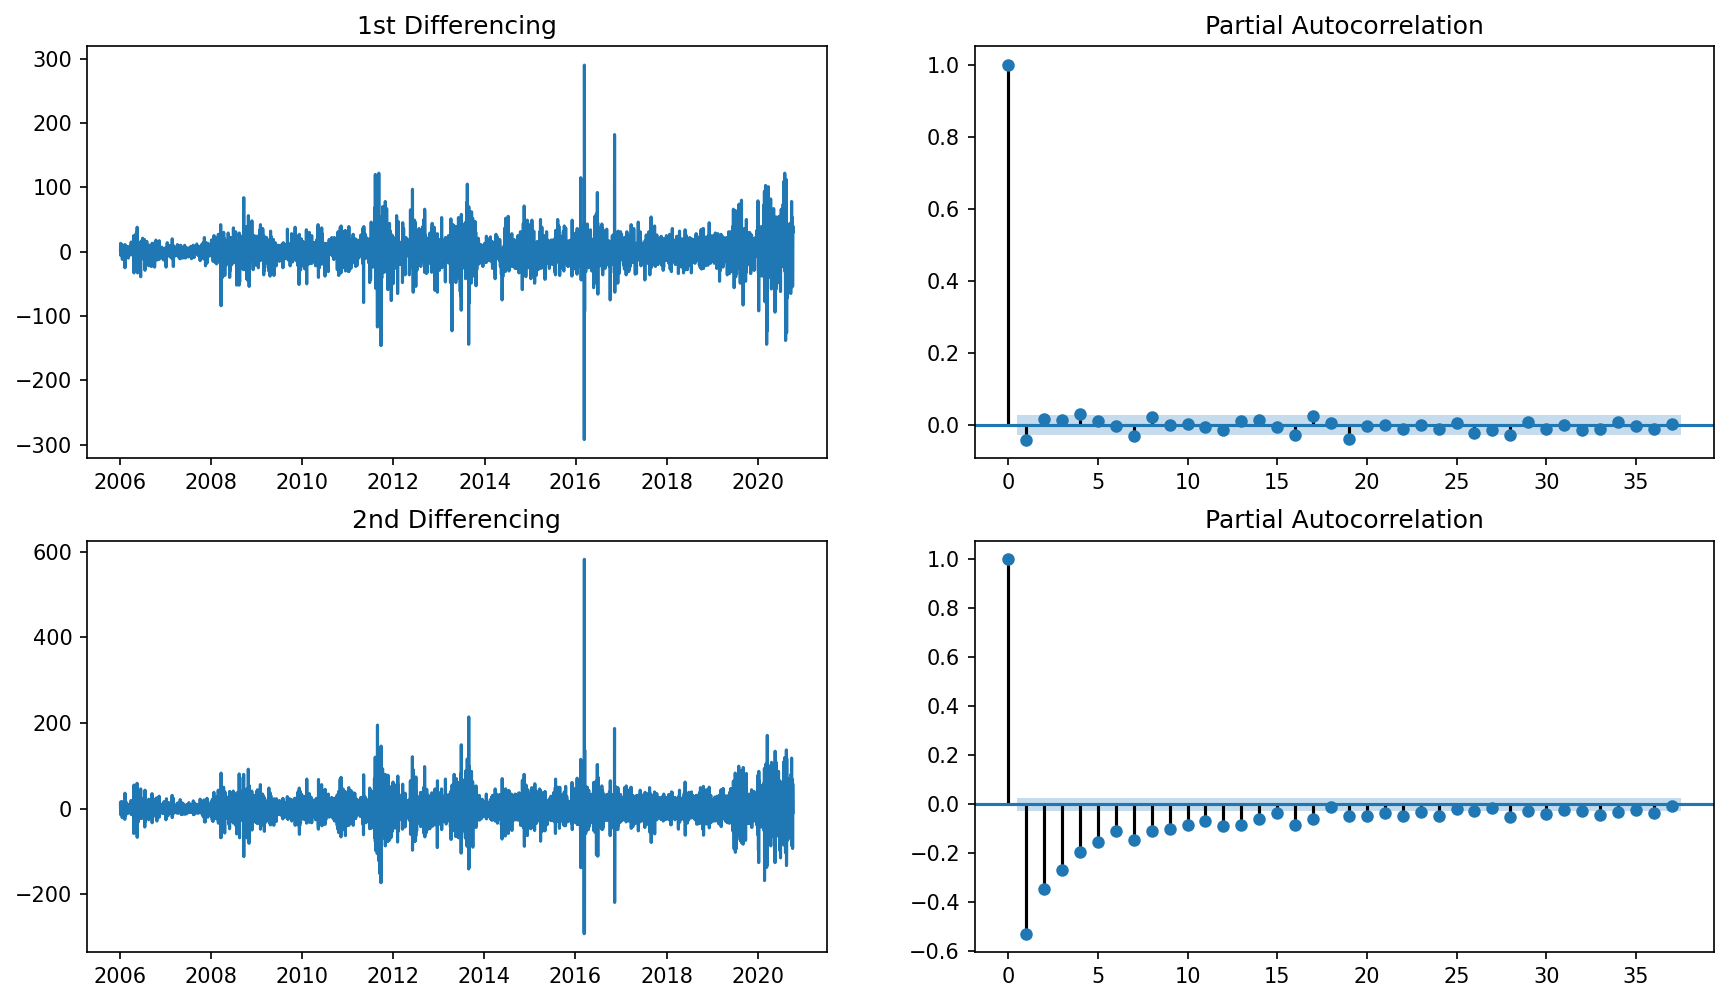

In [ ]:
# PACF plot of 1st differenced series
plt.rcParams.update({'figure.figsize':(14,8), 'figure.dpi':150})

## first order differencing
fig, axes = plt.subplots(2, 2, sharex=False)
axes[0, 0].plot(df['Standard Gold (22 K)'].diff()); axes[0, 0].set_title('1st Differencing')
plot_pacf(df['Standard Gold (22 K)'].diff().dropna(), ax=axes[0, 1])

## second order differencing
axes[1, 0].plot(df['Standard Gold (22 K)'].diff().diff()); axes[1, 0].set_title('2nd Differencing')
plot_pacf(df['Standard Gold (22 K)'].diff().diff().dropna(), ax=axes[1, 1])

plt.show()

PACF lag 1 is quite significant since is well above the significance line.

Hence, P value will tentatively fix 2.

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
# 2,1,1 ARIMA Model
model = ARIMA(df['Standard Gold (22 K)'], order=(2,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                               ARIMA Model Results                                
Dep. Variable:     D.Standard Gold (22 K)   No. Observations:                 4970
Model:                     ARIMA(2, 1, 1)   Log Likelihood              -21997.188
Method:                           css-mle   S.D. of innovations             20.228
Date:                    Wed, 14 Apr 2021   AIC                          44004.375
Time:                            14:45:28   BIC                          44036.931
Sample:                                 1   HQIC                         44015.789
                                                                                  
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                            0.8397      0.295      2.847      0.004       0.262       1.418
ar.L1.D.Standard Gold (22 K)     0.6394      

In [ ]:
# Create Training and Test
train = df['Standard Gold (22 K)'][:-200]
test = df['Standard Gold (22 K)'][-200:]

print(train.shape, test.shape)

(4771,) (200,)


In [ ]:
# Build Model
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit()  

# Forecast
fc, se, conf = fitted.forecast(test.shape[0], alpha=0.05)  # 95% conf

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [ ]:
# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

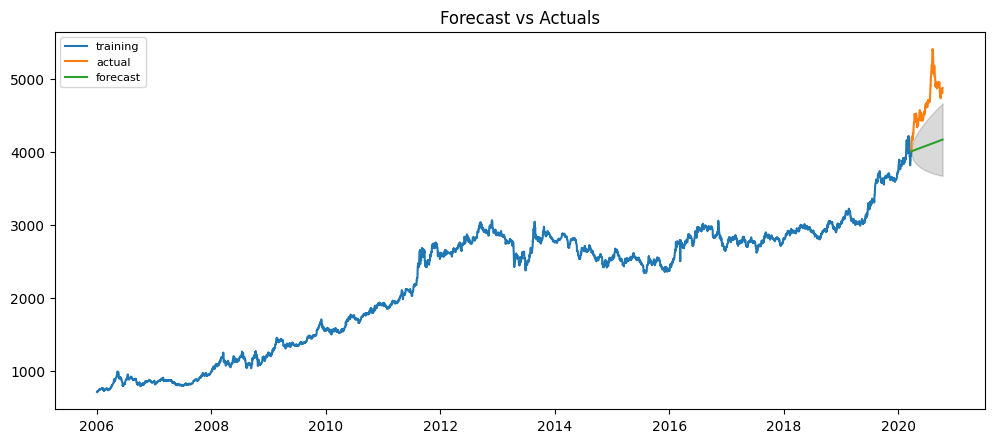

In [ ]:
# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()